In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [53]:
df_fuji = pd.read_csv("../../../DataSet/Fuji/fuji.csv")
# df_envi_inter.info()

In [54]:
df_fuji

,Date,Fuji
0,04/01/2015,24964
1,11/01/2015,10998
2,18/01/2015,6342
3,25/01/2015,7556
4,01/02/2015,36532
...,...,...
164,25/02/2018,7519
165,04/03/2018,1836
166,11/03/2018,2280
167,18/03/2018,6655


In [55]:
df_fuji["Date"] = pd.to_datetime(df_fuji["Date"], format="%d/%m/%Y")
df_fuji.sort_values(by="Date", inplace=True)
df_fuji

,Date,Fuji
0,2015-01-04,24964
1,2015-01-11,10998
2,2015-01-18,6342
3,2015-01-25,7556
4,2015-02-01,36532
...,...,...
164,2018-02-25,7519
165,2018-03-04,1836
166,2018-03-11,2280
167,2018-03-18,6655


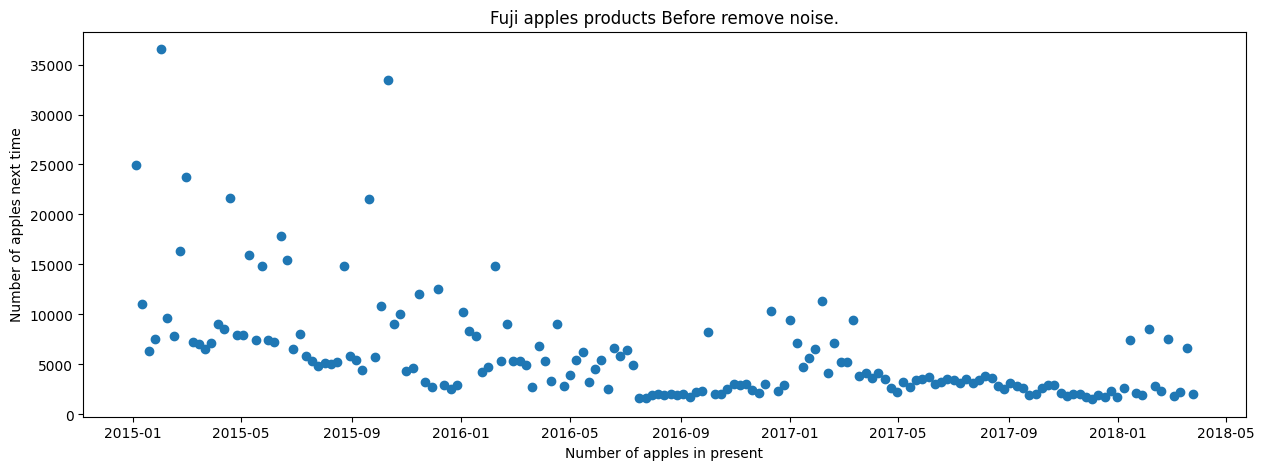

In [56]:
plt.figure(figsize=(15,5))
plt.title("Fuji apples products Before remove noise.")
plt.scatter(df_fuji["Date"], df_fuji["Fuji"])
plt.xlabel("Number of apples in present")
plt.ylabel("Number of apples next time")
plt.show()

PrePocessing Noise

In [57]:
df_fuji = df_fuji[df_fuji["Fuji"] <= 14000]

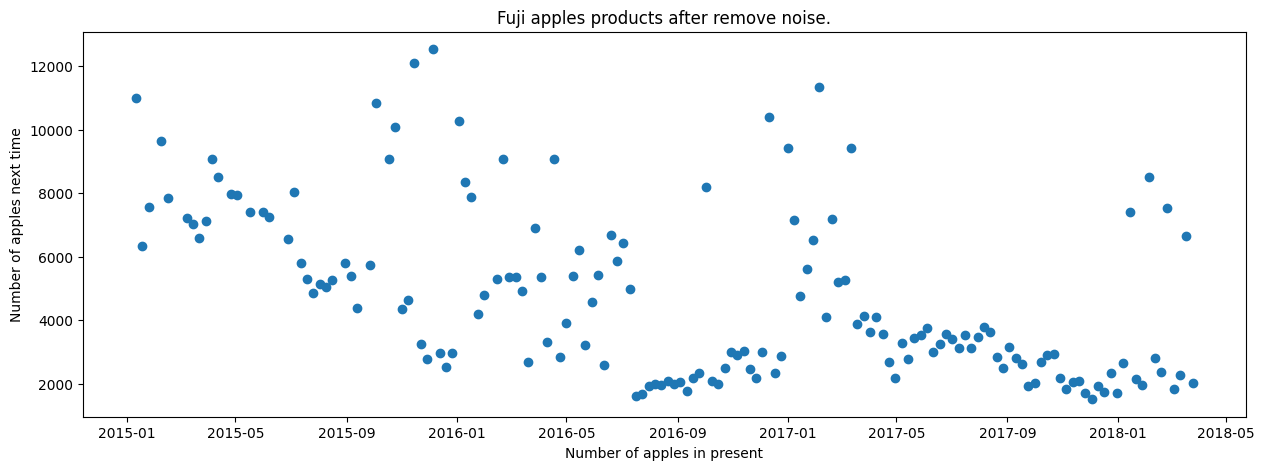

In [58]:
plt.figure(figsize=(15,5))
plt.title("Fuji apples products after remove noise.")
plt.scatter(df_fuji["Date"], df_fuji["Fuji"])
plt.xlabel("Number of apples in present")
plt.ylabel("Number of apples next time")
plt.show()

In [59]:
def writeEvaluate(model, mae:np.float64, mse:np.float64, r2:np.float64, mape:np.float64, filename):
    df = pd.read_csv(filename)
    row_index = df.index.get_loc(df.loc[df['Model'] == model].index[0])
    df.at[row_index,'Mae'] = mae
    df.at[row_index,'Mse'] = mse
    df.at[row_index,'R2'] = r2
    df.at[row_index,'Mape'] = mape

    df.to_csv(filename,encoding='utf-8', sep=',', index=False)

In [60]:
def findBestRandomState(r,t, x, y):
    random = 0
    a = 1000000

    for _ in range(r,t):
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=_)
        buffer = []

        for row in x_test[:,1:]:
            buffer.append(np.mean(row))

        if (buff := mean_absolute_error(y_test[:, 1:], buffer)) < a:
            a = buff
            random = _
    print(a, random)

Function Create X Sequence to Prdict 1

In [61]:
def createSequenceToOneDataSet(r, data:pd.DataFrame):  # Create Sequence DataSet
    df = data.copy()
    i = 1
    
    while i < r:
        df[f'x{i}'] = df['Fuji'].shift(-i)
        i += 1

    if i == r:
        df['y'] = df['Fuji'].shift(-i)

    df = df.dropna(axis=0)
    return df

DataSet for Predict y by Use Sequence X

In [62]:
df = createSequenceToOneDataSet(5, df_fuji)
df

,Date,Fuji,x1,x2,x3,x4,y
1,2015-01-11,10998,6342.0,7556.0,9647.0,7840.0,7206.0
2,2015-01-18,6342,7556.0,9647.0,7840.0,7206.0,7018.0
3,2015-01-25,7556,9647.0,7840.0,7206.0,7018.0,6590.0
5,2015-02-08,9647,7840.0,7206.0,7018.0,6590.0,7120.0
6,2015-02-15,7840,7206.0,7018.0,6590.0,7120.0,9060.0
...,...,...,...,...,...,...,...
159,2018-01-21,2157,1972.0,8511.0,2816.0,2363.0,7519.0
160,2018-01-28,1972,8511.0,2816.0,2363.0,7519.0,1836.0
161,2018-02-04,8511,2816.0,2363.0,7519.0,1836.0,2280.0
162,2018-02-11,2816,2363.0,7519.0,1836.0,2280.0,6655.0


In [63]:
x = np.array(df.drop(columns='y'))
y = np.array(df.drop(['Fuji','x1','x2','x3','x4'],axis=1))

# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x)
# scaler.fit(y.reshape(-1,1))
# y = scaler.transform(y.reshape(-1,1))


Find best randomState for train_test_split

In [64]:
# findBestRandomState(1,100000,x, y)
# seed 76598 MAE: 692.9842105263157

Train test split

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=76598)

x_train = np.array(sorted(x_train, key=lambda x: x[0]))
x_test = np.array(sorted(x_test, key=lambda x: x[0]))
y_train = np.array(sorted(y_train, key=lambda x: x[0]))
y_test = np.array(sorted(y_test, key=lambda x: x[0]))

Baseline Predict

In [66]:
baseline_predict = []

for row in x_test[:,1:]:
    baseline_predict.append(np.mean(row))

In [67]:
mae = mean_absolute_error(y_test[:, 1:], baseline_predict)
mse = mean_squared_error(y_test[:, 1:], baseline_predict)
r2 = r2_score(y_test[:, 1:], baseline_predict)
mape = mean_absolute_percentage_error(y_test[:, 1:], baseline_predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Square Error: {mse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")

writeEvaluate("Baseline",mae,mse,r2,mape,"evaluate.csv")


Mean Absolute Error: 641.8129032258065
Mean Square Error: 713313.4877419356
R2 score: 0.7408341728662499
Mean Absolute Percentage Error: 0.14900596710109434


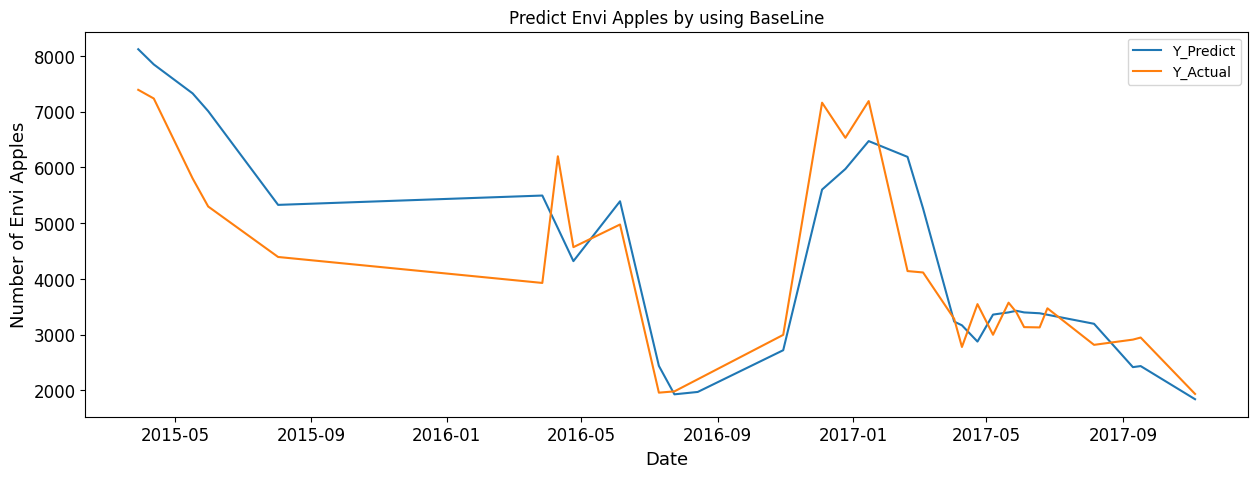

In [68]:
plt.figure(figsize=(15, 5))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Date", fontsize=13)
plt.ylabel("Number of Envi Apples", fontsize=13)

plt.plot(x_test[:, :1], baseline_predict, label="Y_Predict")
plt.plot(x_test[:,:1], y_test[:, 1:], label="Y_Actual")


plt.title("Predict Envi Apples by using BaseLine")
plt.legend()
plt.show()